In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 55_5_25.xlsx to 55_5_25.xlsx


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Read Excel (uploaded file)
file_path = "55_5_25.xlsx"
data = pd.read_excel(file_path)
data.columns = data.columns.str.strip()  # Clean column headers

# Confirm column names
print(" Columns:", data.columns.tolist())


 Columns: ['ID', 'X', 'Y', 'Node', 'FINIT', 'FINIT_U']


In [ ]:
# Coordinates
x_raw = data['X'].values.astype(np.float32)
y_raw = data['Y'].values.astype(np.float32)

# Normalize X and Y to [0, 1]
x_norm = (x_raw - x_raw.min()) / (x_raw.max() - x_raw.min())
y_norm = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())

x_data = torch.tensor(x_norm).unsqueeze(1)
y_data = torch.tensor(y_norm).unsqueeze(1)
xy_data = torch.cat([x_data, y_data], dim=1)

# Pressure head (in meters)
boundary_h = torch.tensor(data['FINIT'].values, dtype=torch.float32).unsqueeze(1)


In [ ]:
class SimplePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.net.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model = SimplePINN()


In [ ]:

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_log = []

for epoch in range(5000):
    optimizer.zero_grad()
    loss = criterion(model(xy_data), boundary_h)
    loss.backward()
    optimizer.step()
    loss_log.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d} | BC Loss: {loss.item():.6f}")


Epoch    0 | BC Loss: 2166.356934
Epoch  500 | BC Loss: 105.071953
Epoch 1000 | BC Loss: 17.375620
Epoch 1500 | BC Loss: 9.742355
Epoch 2000 | BC Loss: 7.443058
Epoch 2500 | BC Loss: 5.937243
Epoch 3000 | BC Loss: 4.598839
Epoch 3500 | BC Loss: 3.295567
Epoch 4000 | BC Loss: 2.030600
Epoch 4500 | BC Loss: 1.133396


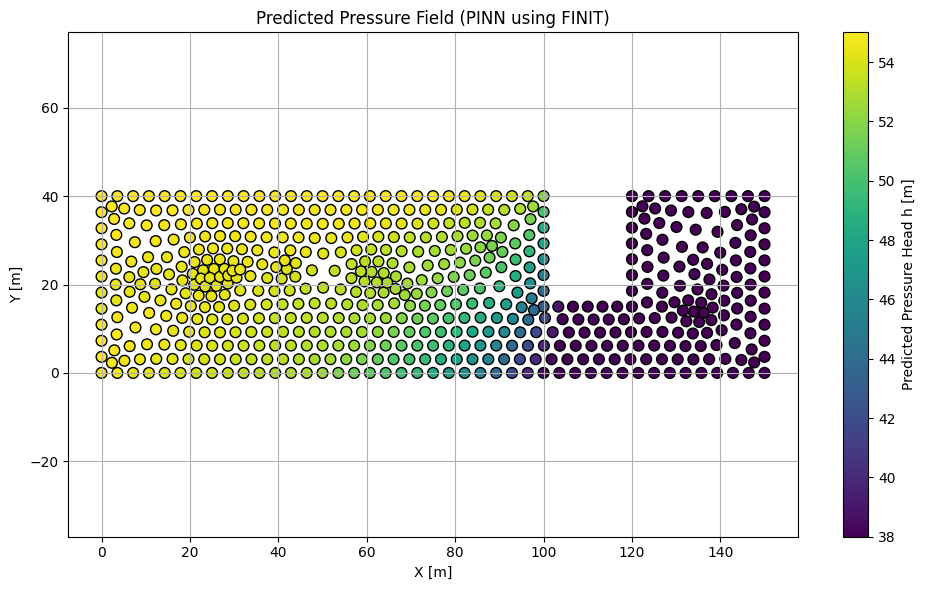

In [ ]:
h_pred = model(xy_data).detach().numpy()

plt.figure(figsize=(10, 6))
sc = plt.scatter(x_raw, y_raw, c=h_pred.squeeze(), cmap='viridis',
                 s=60, edgecolors='k', vmin=38, vmax=55)
plt.colorbar(sc, label='Predicted Pressure Head h [m]')
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Predicted Pressure Field (PINN using FINIT)")
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


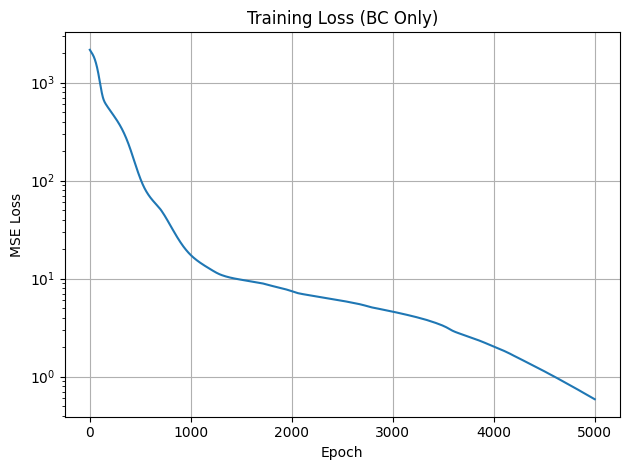

In [ ]:
plt.figure()
plt.plot(loss_log)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss (BC Only)")
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0 | Total Loss: 0.665013 | BC: 0.660691 | PDE: 0.004322
Epoch 500 | Total Loss: 0.027695 | BC: 0.027327 | PDE: 0.000368
Epoch 1000 | Total Loss: 0.021431 | BC: 0.021108 | PDE: 0.000322
Epoch 1500 | Total Loss: 0.019793 | BC: 0.019464 | PDE: 0.000329
Epoch 2000 | Total Loss: 0.019139 | BC: 0.019019 | PDE: 0.000120
Epoch 2500 | Total Loss: 0.018741 | BC: 0.018510 | PDE: 0.000231
Epoch 3000 | Total Loss: 0.018242 | BC: 0.018048 | PDE: 0.000194
Epoch 3500 | Total Loss: 0.020464 | BC: 0.018394 | PDE: 0.002069
Epoch 4000 | Total Loss: 0.017434 | BC: 0.017276 | PDE: 0.000158
Epoch 4500 | Total Loss: 0.017132 | BC: 0.016976 | PDE: 0.000155


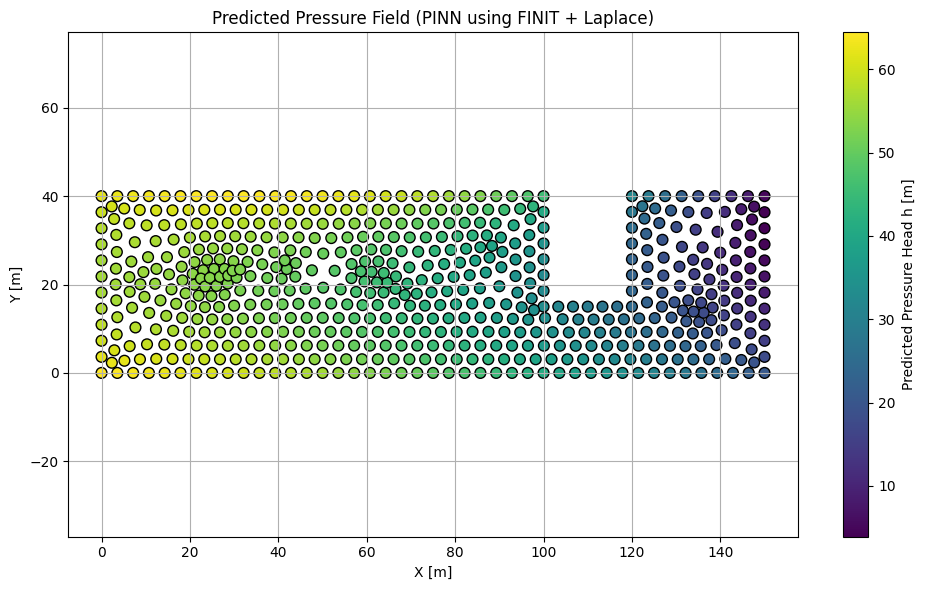

In [ ]:
# ─── 1. Setup ─────────────────────────────────────────────
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Upload your Excel in Colab first, then adjust this path:
file_path = "/content/55_5_25.xlsx"
data = pd.read_excel(file_path)
data.columns = data.columns.str.strip()  # clean headers

# ─── 2. Normalize Inputs ─────────────────────────────────
x_raw = data['X'].values.astype(np.float32)
y_raw = data['Y'].values.astype(np.float32)
h_raw = data['FINIT'].values.astype(np.float32)

x_norm = (x_raw - x_raw.min()) / (x_raw.max() - x_raw.min())
y_norm = (y_raw - y_raw.min()) / (y_raw.max() - y_raw.min())
h_min, h_max = h_raw.min(), h_raw.max()
h_range = h_max - h_min
h_norm = (h_raw - h_min) / h_range

x_data = torch.tensor(x_norm).unsqueeze(1)
y_data = torch.tensor(y_norm).unsqueeze(1)
xy_data = torch.cat([x_data, y_data], dim=1)
h_data = torch.tensor(h_norm).unsqueeze(1)

# ─── 3. Define PINN ──────────────────────────────────────
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

model = PINN()

# ─── 4. Loss Functions ───────────────────────────────────
def boundary_loss(xy, h_true):
    h_pred = model(xy)
    return torch.mean((h_pred - h_true)**2)

def laplace_loss(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grads = torch.autograd.grad(h, xy, grad_outputs=torch.ones_like(h), create_graph=True)[0]
    h_x, h_y = grads[:, 0:1], grads[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    laplacian = h_xx + h_yy
    return torch.mean(laplacian**2)

# ─── 5. Training ─────────────────────────────────────────
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_log = []

for epoch in range(5000):
    optimizer.zero_grad()
    loss_bc = boundary_loss(xy_data, h_data)
    loss_pde = laplace_loss(xy_data)  # we apply Laplace everywhere
    total_loss = loss_bc + loss_pde
    total_loss.backward()
    optimizer.step()

    loss_log.append(total_loss.item())
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Total Loss: {total_loss.item():.6f} | BC: {loss_bc.item():.6f} | PDE: {loss_pde.item():.6f}")

# ─── 6. Predict and Plot ─────────────────────────────────
h_pred_norm = model(xy_data).detach().numpy()
h_pred = h_pred_norm * h_range + h_min  # denormalize

plt.figure(figsize=(10, 6))
sc = plt.scatter(x_raw, y_raw, c=h_pred.squeeze(), cmap='viridis', edgecolors='k', s=60)
plt.colorbar(sc, label='Predicted Pressure Head h [m]')
plt.title("Predicted Pressure Field (PINN using FINIT + Laplace)")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()


Saving 55_5_25.xlsx to 55_5_25 (1).xlsx
Epoch 0 | Total: 1982.0576 | BC: 1982.0492 | PDE: 0.0085
Epoch 500 | Total: 451.3412 | BC: 451.3074 | PDE: 0.0337
Epoch 1000 | Total: 366.0613 | BC: 366.0510 | PDE: 0.0103
Epoch 1500 | Total: 364.9509 | BC: 364.9462 | PDE: 0.0047
Epoch 2000 | Total: 364.9099 | BC: 364.9071 | PDE: 0.0029
Epoch 2500 | Total: 354.8124 | BC: 352.7241 | PDE: 2.0883
Epoch 3000 | Total: 93.2844 | BC: 88.5065 | PDE: 4.7779
Epoch 3500 | Total: 68.8376 | BC: 67.3198 | PDE: 1.5177
Epoch 4000 | Total: 55.6114 | BC: 53.8676 | PDE: 1.7438
Epoch 4500 | Total: 43.4348 | BC: 41.9521 | PDE: 1.4827


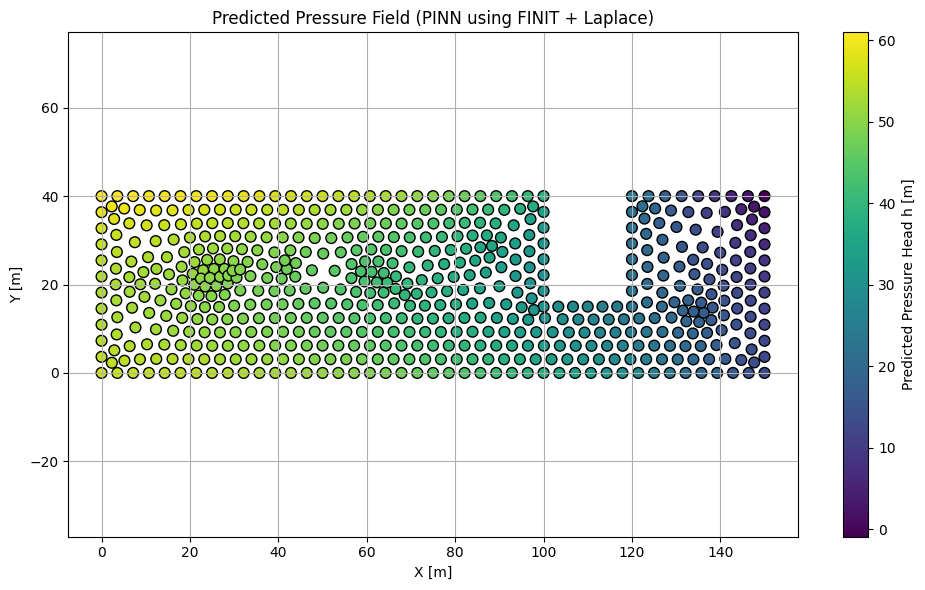

In [ ]:
# 1. Install dependencies (Colab only)
# !pip install openpyxl

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2. Upload file manually in Colab or use local path in Jupyter
from google.colab import files
uploaded = files.upload()  # Choose '55_5_25.xlsx'

# 3. Load Excel
data = pd.read_excel("55_5_25.xlsx")
data.columns = data.columns.str.strip()

# 4. Extract raw data
x_raw = data["X"].values.astype(np.float32)
y_raw = data["Y"].values.astype(np.float32)
h_raw = data["FINIT"].values.astype(np.float32)

# 5. Normalize coordinates
x_min, x_max = x_raw.min(), x_raw.max()
y_min, y_max = y_raw.min(), y_raw.max()
x_norm = (x_raw - x_min) / (x_max - x_min)
y_norm = (y_raw - y_min) / (y_max - y_min)

# 6. Convert to tensors
xy_all = torch.tensor(np.stack([x_norm, y_norm], axis=1), dtype=torch.float32)
h_all = torch.tensor(h_raw, dtype=torch.float32).unsqueeze(1)

# 7. Split boundary and interior
boundary_mask = (
    (np.isclose(x_raw, x_min)) | (np.isclose(x_raw, x_max)) |
    (np.isclose(y_raw, y_min)) | (np.isclose(y_raw, y_max))
)
interior_mask = ~boundary_mask

xy_boundary = xy_all[boundary_mask]
h_boundary = h_all[boundary_mask]
xy_interior = xy_all[interior_mask]

# 8. PINN model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN()

# 9. Loss functions
def loss_dirichlet(xy, h_true):
    return torch.mean((model(xy) - h_true)**2)

def loss_laplace(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    h_x, h_y = grad[:, 0:1], grad[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    return torch.mean((h_xx + h_yy)**2)

# 10. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 11. Training loop
for epoch in range(5000):
    optimizer.zero_grad()
    loss_bc = loss_dirichlet(xy_boundary, h_boundary)
    loss_pde = loss_laplace(xy_interior)
    loss_total = loss_bc + loss_pde
    loss_total.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Total: {loss_total.item():.4f} | BC: {loss_bc.item():.4f} | PDE: {loss_pde.item():.4f}")

# 12. Predict and plot
with torch.no_grad():
    h_pred = model(xy_all).numpy()

plt.figure(figsize=(10, 6))
sc = plt.scatter(x_raw, y_raw, c=h_pred.squeeze(), cmap="viridis", edgecolors="k", s=60)
plt.colorbar(sc, label="Predicted Pressure Head h [m]")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Predicted Pressure Field (PINN using FINIT + Laplace)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0 | Total: 2021.0640 | BC: 2021.0573 | PDE: 0.0024 | NeuY: 0.0033 | NeuX: 0.0009
Epoch 500 | Total: 452.2443 | BC: 452.2042 | PDE: 0.0318 | NeuY: 0.0083 | NeuX: 0.0000
Epoch 1000 | Total: 365.9966 | BC: 365.9814 | PDE: 0.0114 | NeuY: 0.0037 | NeuX: 0.0001
Epoch 1500 | Total: 364.5735 | BC: 364.5042 | PDE: 0.0485 | NeuY: 0.0112 | NeuX: 0.0096
Epoch 2000 | Total: 303.0487 | BC: 284.4467 | PDE: 4.2001 | NeuY: 1.8291 | NeuX: 12.5727
Epoch 2500 | Total: 179.6609 | BC: 166.1151 | PDE: 5.0489 | NeuY: 2.9650 | NeuX: 5.5319
Epoch 3000 | Total: 137.2395 | BC: 125.4939 | PDE: 3.8812 | NeuY: 3.0793 | NeuX: 4.7851
Epoch 3500 | Total: 115.2467 | BC: 104.5852 | PDE: 3.3179 | NeuY: 3.0849 | NeuX: 4.2588
Epoch 4000 | Total: 108.7115 | BC: 98.9738 | PDE: 2.6145 | NeuY: 3.1916 | NeuX: 3.9316
Epoch 4500 | Total: 106.2331 | BC: 96.0023 | PDE: 2.9954 | NeuY: 3.3389 | NeuX: 3.8965


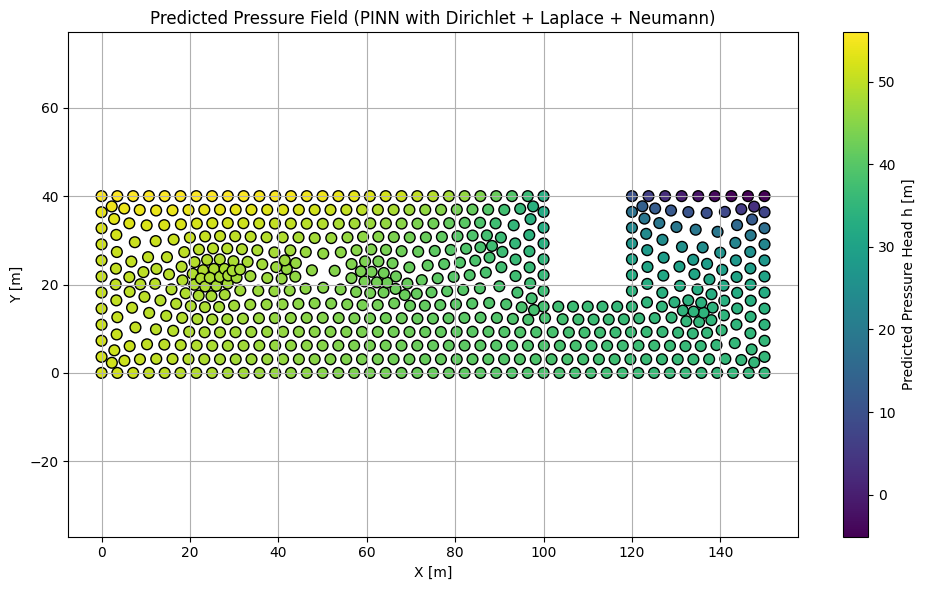

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you're using Google Colab:
# from google.colab import files
# uploaded = files.upload()  # Upload "55_5_25.xlsx"

# 1. Load data
data = pd.read_excel("55_5_25.xlsx")
data.columns = data.columns.str.strip()

# 2. Raw coordinate and target values
x_raw = data["X"].values.astype(np.float32)
y_raw = data["Y"].values.astype(np.float32)
h_raw = data["FINIT"].values.astype(np.float32)

# 3. Normalize coordinates
x_min, x_max = x_raw.min(), x_raw.max()
y_min, y_max = y_raw.min(), y_raw.max()
x_norm = (x_raw - x_min) / (x_max - x_min)
y_norm = (y_raw - y_min) / (y_max - y_min)

xy_all = torch.tensor(np.stack([x_norm, y_norm], axis=1), dtype=torch.float32)
h_all = torch.tensor(h_raw, dtype=torch.float32).unsqueeze(1)

# 4. Identify boundary and interior
boundary_mask = (
    (np.isclose(x_raw, x_min)) | (np.isclose(x_raw, x_max)) |
    (np.isclose(y_raw, y_min)) | (np.isclose(y_raw, y_max))
)
interior_mask = ~boundary_mask

xy_boundary = xy_all[boundary_mask]
h_boundary = h_all[boundary_mask]
xy_interior = xy_all[interior_mask]

# 5. Neumann boundary masks (bottom and dam wall)
bottom_mask = np.isclose(y_raw, y_min)
dam_wall_mask = np.isclose(x_raw, x_max)

xy_neu_bottom = xy_all[bottom_mask]
xy_neu_dam = xy_all[dam_wall_mask]

# 6. Define model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN()

# 7. Loss functions
def loss_dirichlet(xy, h_true):
    return torch.mean((model(xy) - h_true) ** 2)

def loss_laplace(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grads = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    h_x, h_y = grads[:, 0:1], grads[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    return torch.mean((h_xx + h_yy)**2)

def loss_neumann_y_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 1:2] ** 2)

def loss_neumann_x_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 0:1] ** 2)

# 8. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 9. Training
for epoch in range(5000):
    optimizer.zero_grad()
    loss_bc = loss_dirichlet(xy_boundary, h_boundary)
    loss_pde = loss_laplace(xy_interior)
    loss_neu_y = loss_neumann_y_zero(xy_neu_bottom)
    loss_neu_x = loss_neumann_x_zero(xy_neu_dam)
    total_loss = loss_bc + loss_pde + loss_neu_x + loss_neu_y
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Total: {total_loss.item():.4f} | BC: {loss_bc.item():.4f} | PDE: {loss_pde.item():.4f} | NeuY: {loss_neu_y.item():.4f} | NeuX: {loss_neu_x.item():.4f}")

# 10. Prediction and Plot
with torch.no_grad():
    h_pred = model(xy_all).numpy()

plt.figure(figsize=(10, 6))
sc = plt.scatter(x_raw, y_raw, c=h_pred.squeeze(), cmap="viridis", edgecolors="k", s=60)
plt.colorbar(sc, label="Predicted Pressure Head h [m]")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Predicted Pressure Field (PINN with Dirichlet + Laplace + Neumann)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch     0 | Total: 12.9748 | BC: 1.2909 | PDE: 0.0241 | NeuY: 0.0401 | NeuX: 0.0013
Epoch   500 | Total: 0.6186 | BC: 0.0452 | PDE: 0.0237 | NeuY: 0.0045 | NeuX: 0.1384
Epoch  1000 | Total: 0.5082 | BC: 0.0381 | PDE: 0.0244 | NeuY: 0.0179 | NeuX: 0.0844
Epoch  1500 | Total: 0.3826 | BC: 0.0283 | PDE: 0.0236 | NeuY: 0.0208 | NeuX: 0.0555
Epoch  2000 | Total: 0.2569 | BC: 0.0182 | PDE: 0.0193 | NeuY: 0.0185 | NeuX: 0.0369
Epoch  2500 | Total: 0.2410 | BC: 0.0168 | PDE: 0.0187 | NeuY: 0.0181 | NeuX: 0.0359
Epoch  3000 | Total: 0.2334 | BC: 0.0162 | PDE: 0.0174 | NeuY: 0.0186 | NeuX: 0.0355
Epoch  3500 | Total: 0.2279 | BC: 0.0158 | PDE: 0.0148 | NeuY: 0.0196 | NeuX: 0.0354
Epoch  4000 | Total: 0.2252 | BC: 0.0156 | PDE: 0.0135 | NeuY: 0.0204 | NeuX: 0.0355
Epoch  4500 | Total: 0.2226 | BC: 0.0154 | PDE: 0.0137 | NeuY: 0.0205 | NeuX: 0.0347
Epoch  5000 | Total: 0.2205 | BC: 0.0152 | PDE: 0.0132 | NeuY: 0.0205 | NeuX: 0.0347
Epoch  5500 | Total: 0.2202 | BC: 0.0152 | PDE: 0.0135 | NeuY: 0

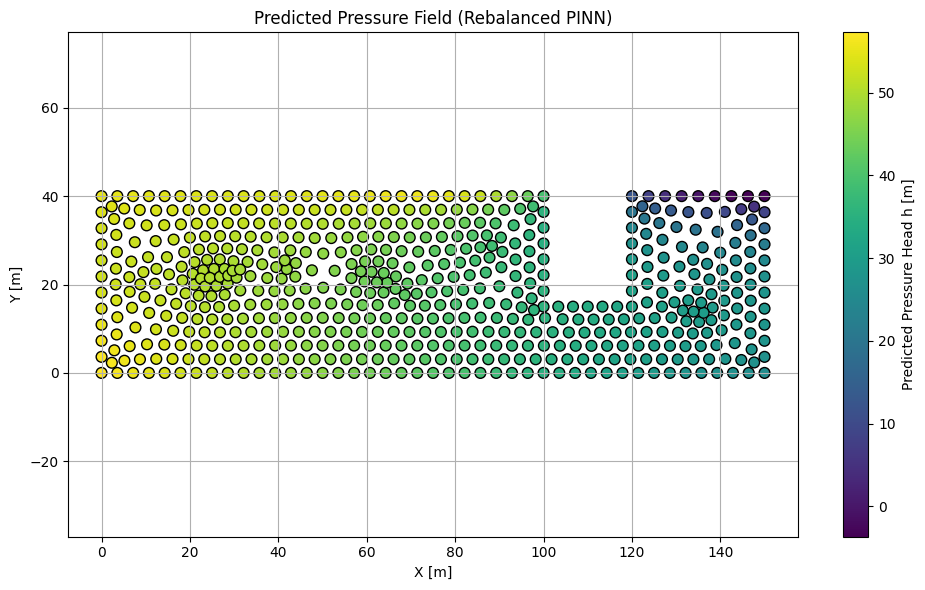

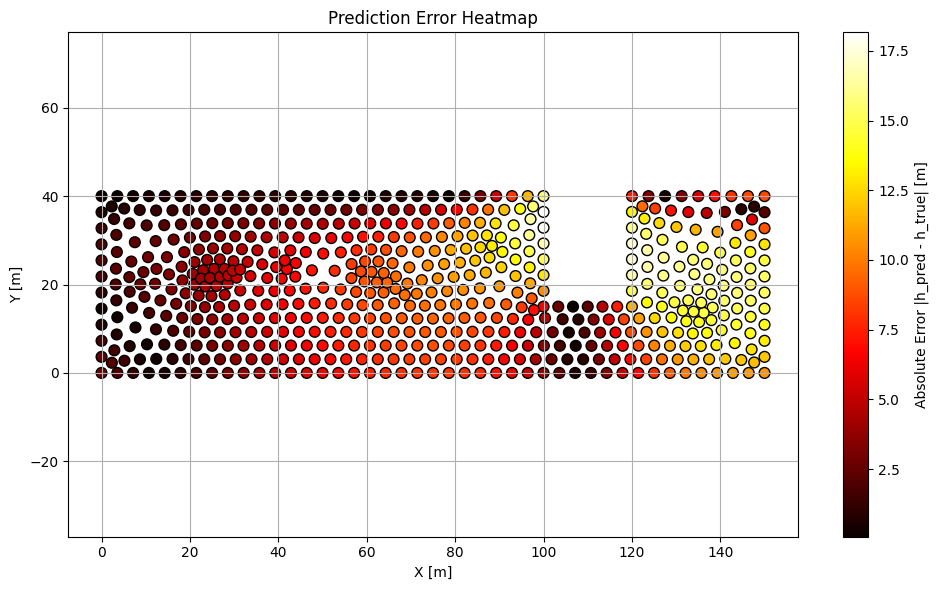

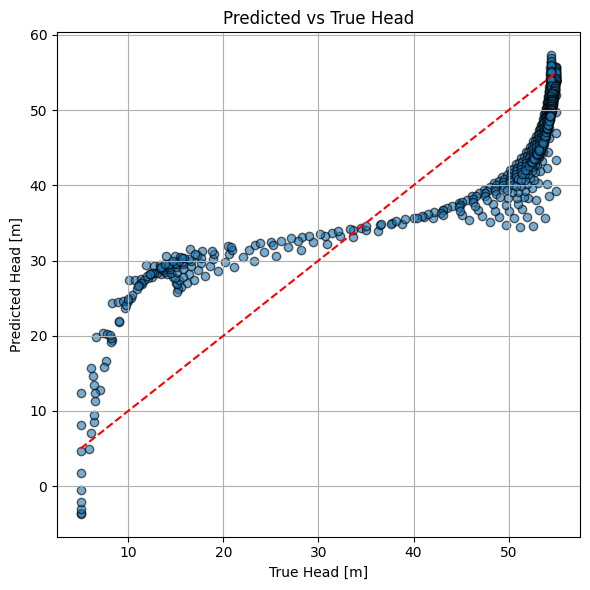

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# 1. Load data
data = pd.read_excel("55_5_25.xlsx")
data.columns = data.columns.str.strip()
x_raw = data["X"].values.astype(np.float32)
y_raw = data["Y"].values.astype(np.float32)
h_raw = data["FINIT"].values.astype(np.float32)

# 2. Normalize coordinates and head
x_min, x_max = x_raw.min(), x_raw.max()
y_min, y_max = y_raw.min(), y_raw.max()
h_max = h_raw.max()

x_norm = (x_raw - x_min) / (x_max - x_min)
y_norm = (y_raw - y_min) / (y_max - y_min)
h_norm = h_raw / h_max

xy_all = torch.tensor(np.stack([x_norm, y_norm], axis=1), dtype=torch.float32)
h_all = torch.tensor(h_norm, dtype=torch.float32).unsqueeze(1)

# 3. Boundary and interior masks
boundary_mask = (
    (np.isclose(x_raw, x_min)) | (np.isclose(x_raw, x_max)) |
    (np.isclose(y_raw, y_min)) | (np.isclose(y_raw, y_max))
)
interior_mask = ~boundary_mask

xy_boundary = xy_all[boundary_mask]
h_boundary = h_all[boundary_mask]
xy_interior = xy_all[interior_mask]

# 4. Neumann masks
bottom_mask = np.isclose(y_raw, y_min)
dam_wall_mask = np.isclose(x_raw, x_max)

xy_neu_bottom = xy_all[bottom_mask]
xy_neu_dam = xy_all[dam_wall_mask]

# 5. PINN model (moderate depth)
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN()

# 6. Loss functions
def loss_dirichlet(xy, h_true):
    return torch.mean((model(xy) - h_true) ** 2)

def loss_laplace(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grads = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    h_x = grads[:, 0:1]
    h_y = grads[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    return torch.mean((h_xx + h_yy) ** 2)

def loss_neumann_y_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 1:2] ** 2)

def loss_neumann_x_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 0:1] ** 2)

# 7. Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

# 8. Training loop (emphasize data fit)
for epoch in range(10000):
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)

    total_loss = 10.0 * bc + 1.0 * pde + 1.0 * neu_y + 1.0 * neu_x
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Total: {total_loss.item():.4f} | BC: {bc.item():.4f} | PDE: {pde.item():.4f} | NeuY: {neu_y.item():.4f} | NeuX: {neu_x.item():.4f}")

# 9. Prediction and Evaluation
with torch.no_grad():
    h_pred = model(xy_all).numpy() * h_max

h_true = h_raw
h_pred_vals = h_pred.squeeze()
r2 = r2_score(h_true, h_pred_vals)
print(f"R² Score: {r2:.5f}")

# 10. Plots
plt.figure(figsize=(10, 6))
sc = plt.scatter(x_raw, y_raw, c=h_pred_vals, cmap="viridis", edgecolors="k", s=60)
plt.colorbar(sc, label="Predicted Pressure Head h [m]")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Predicted Pressure Field (Rebalanced PINN)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

# Error heatmap
error = np.abs(h_true - h_pred_vals)
plt.figure(figsize=(10, 6))
sc_err = plt.scatter(x_raw, y_raw, c=error, cmap="hot", edgecolors="k", s=60)
plt.colorbar(sc_err, label="Absolute Error |h_pred - h_true| [m]")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Prediction Error Heatmap")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicted vs True head
plt.figure(figsize=(6, 6))
plt.scatter(h_true, h_pred_vals, alpha=0.6, edgecolors="k")
plt.plot([h_true.min(), h_true.max()], [h_true.min(), h_true.max()], 'r--')
plt.xlabel("True Head [m]")
plt.ylabel("Predicted Head [m]")
plt.title("Predicted vs True Head")
plt.grid(True)
plt.tight_layout()
plt.show()


Saving 55_5_25.csv to 55_5_25 (3).csv
Epoch 0 | Total Loss: 67.0835 | R²: -5.21020
Epoch 500 | Total Loss: 3.5688 | R²: 0.72541
Epoch 1000 | Total Loss: 3.3855 | R²: 0.73701
Epoch 1500 | Total Loss: 3.0927 | R²: 0.74383
Epoch 2000 | Total Loss: 2.7066 | R²: 0.75148
Epoch 2500 | Total Loss: 2.3539 | R²: 0.75117
Epoch 3000 | Total Loss: 2.1641 | R²: 0.75716
Epoch 3500 | Total Loss: 2.0375 | R²: 0.76030
Epoch 4000 | Total Loss: 2.2584 | R²: 0.78516
Epoch 4500 | Total Loss: 1.8030 | R²: 0.77531
Epoch 5000 | Total Loss: 1.7454 | R²: 0.78461
Epoch 5500 | Total Loss: 1.6580 | R²: 0.78246
Epoch 6000 | Total Loss: 1.6030 | R²: 0.78657
Epoch 6500 | Total Loss: 1.5645 | R²: 0.79437
Epoch 7000 | Total Loss: 1.5122 | R²: 0.79532
Epoch 7500 | Total Loss: 1.4682 | R²: 0.79790
Epoch 8000 | Total Loss: 1.4344 | R²: 0.79944
Epoch 8500 | Total Loss: 1.3855 | R²: 0.80339
Epoch 9000 | Total Loss: 1.3491 | R²: 0.80771
Epoch 9500 | Total Loss: 1.3461 | R²: 0.80735
Final R² Score: 0.81134


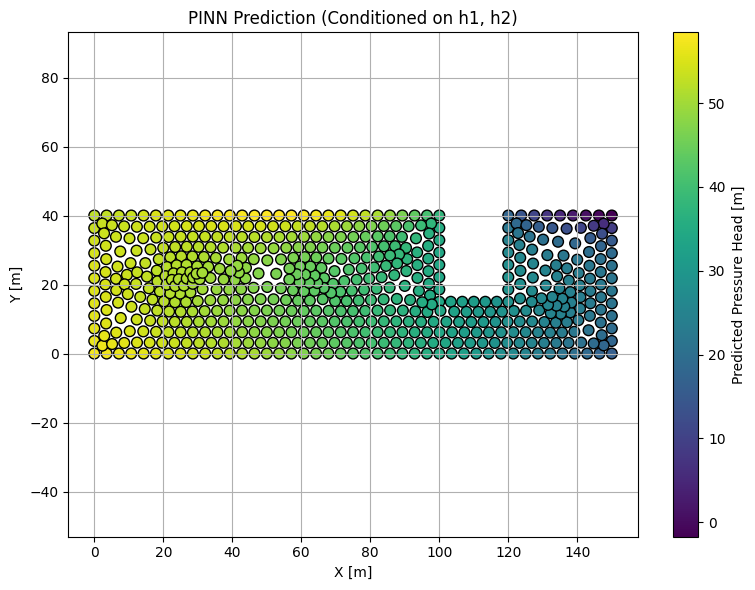

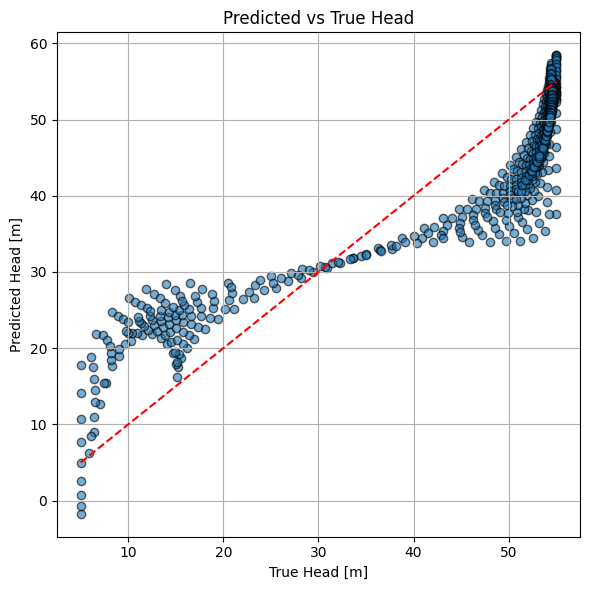

In [ ]:
# 🧠 Physics-Informed Neural Network with Variable Head Inputs (Google Colab Ver)

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from google.colab import files
uploaded = files.upload()  # ← Upload your 55_5_25.csv file

# Load CSV data
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)

# Extract h1, h2 from filename e.g. "55_5_25.csv" → h1=55, h2=5
parts = filename.split('.')[0].split('_')
h1 = float(parts[0])
h2 = float(parts[1])

# Normalize input coordinates and add h1, h2 as constant columns
x_raw = data["X"].values.astype(np.float32)
y_raw = data["Y"].values.astype(np.float32)
h_raw = data["FINIT"].values.astype(np.float32)

x_min, x_max = x_raw.min(), x_raw.max()
y_min, y_max = y_raw.min(), y_raw.max()
h_max = h_raw.max()

x_norm = (x_raw - x_min) / (x_max - x_min)
y_norm = (y_raw - y_min) / (y_max - y_min)
h_norm = h_raw / h_max

# 📌 Add h1, h2 as constant inputs (normalized by h_max for scale match)
h1_norm = h1 / h_max
h2_norm = h2 / h_max
h1_column = np.full_like(x_norm, h1_norm)
h2_column = np.full_like(x_norm, h2_norm)

inputs = np.stack([x_norm, y_norm, h1_column, h2_column], axis=1)
xy_all = torch.tensor(inputs, dtype=torch.float32)
h_all = torch.tensor(h_norm, dtype=torch.float32).unsqueeze(1)

# Masking
boundary_mask = (
    (np.isclose(x_raw, x_min)) | (np.isclose(x_raw, x_max)) |
    (np.isclose(y_raw, y_min)) | (np.isclose(y_raw, y_max))
)
interior_mask = ~boundary_mask

xy_boundary = xy_all[boundary_mask]
h_boundary = h_all[boundary_mask]
xy_interior = xy_all[interior_mask]

# Neumann masks
bottom_mask = np.isclose(y_raw, y_min)
dam_wall_mask = np.isclose(x_raw, x_max)
xy_neu_bottom = xy_all[bottom_mask]
xy_neu_dam = xy_all[dam_wall_mask]

# ✅ Define model with 4 inputs: x, y, h1, h2
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN()

# 🔧 Loss functions
def loss_dirichlet(xy, h_true): return torch.mean((model(xy) - h_true)**2)

def loss_laplace(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grads = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    h_x, h_y = grads[:, 0:1], grads[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    return torch.mean((h_xx + h_yy)**2)

def loss_neumann_y_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 1:2]**2)

def loss_neumann_x_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 0:1]**2)

# 🧪 Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 🧠 Train
for epoch in range(10000):
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)

    total_loss = 100.0 * bc + 100.0 * pde + 1.0 * neu_y + 1.0 * neu_x
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Total Loss: {total_loss.item():.4f} | R²: {r2_score(h_raw, model(xy_all).detach().numpy().squeeze() * h_max):.5f}")

# 🎯 Prediction
with torch.no_grad():
    h_pred = model(xy_all).numpy().squeeze() * h_max

# 🔍 Evaluate
r2 = r2_score(h_raw, h_pred)
print(f"Final R² Score: {r2:.5f}")

# 📊 Plot prediction
plt.figure(figsize=(8, 6))
sc = plt.scatter(x_raw, y_raw, c=h_pred, cmap="viridis", edgecolors="k", s=60)
plt.colorbar(sc, label="Predicted Pressure Head [m]")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("PINN Prediction (Conditioned on h1, h2)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicted vs True head
h_true = h_raw
h_pred_vals = h_pred

plt.figure(figsize=(6, 6))
plt.scatter(h_true, h_pred_vals, alpha=0.6, edgecolors="k")
plt.plot([h_true.min(), h_true.max()], [h_true.min(), h_true.max()], 'r--')
plt.xlabel("True Head [m]")
plt.ylabel("Predicted Head [m]")
plt.title("Predicted vs True Head")
plt.grid(True)
plt.tight_layout()
plt.show()



Saving 55_5_25.csv to 55_5_25 (4).csv
Epoch     0 | Total: 12.4040 | R²: -2.12221
Epoch   500 | Total: 0.8652 | R²: 0.67647
Epoch  1000 | Total: 0.3766 | R²: 0.77156
Epoch  1500 | Total: 0.3521 | R²: 0.78241
Epoch  2000 | Total: 0.3398 | R²: 0.78546
Epoch  2500 | Total: 0.3286 | R²: 0.78671
Epoch  3000 | Total: 0.3144 | R²: 0.78613
Epoch  3500 | Total: 0.2899 | R²: 0.78314
Epoch  4000 | Total: 0.2410 | R²: 0.76081
Epoch  4500 | Total: 0.1940 | R²: 0.70505
Epoch  5000 | Total: 0.1736 | R²: 0.66922
Epoch  5500 | Total: 0.1662 | R²: 0.65261
Epoch  6000 | Total: 0.1646 | R²: 0.64970
Epoch  6500 | Total: 0.2118 | R²: 0.64366
Epoch  7000 | Total: 0.1601 | R²: 0.65022
Epoch  7500 | Total: 0.1639 | R²: 0.65143
Epoch  8000 | Total: 0.1601 | R²: 0.65489
Epoch  8500 | Total: 0.1573 | R²: 0.65317
Epoch  9000 | Total: 0.1561 | R²: 0.65318
Epoch  9500 | Total: 0.1538 | R²: 0.65249

🔧 Switching to L-BFGS optimizer...

📈 Final R² Score: 0.62075


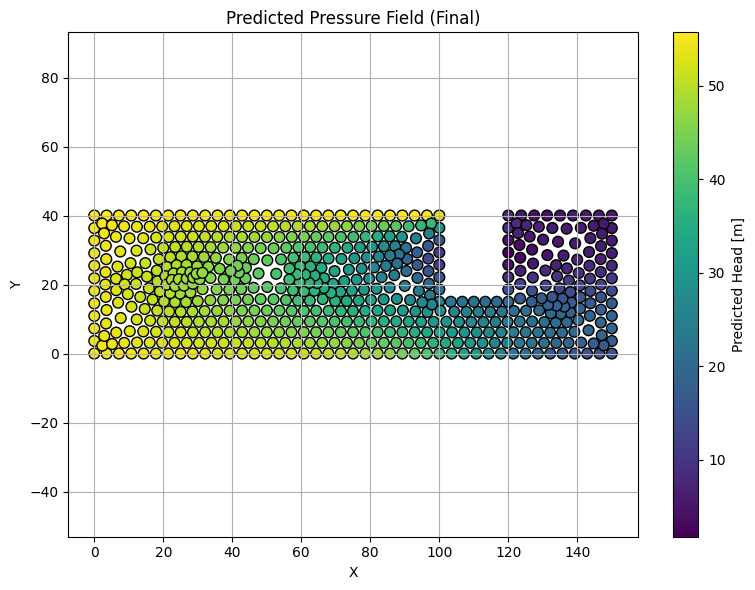

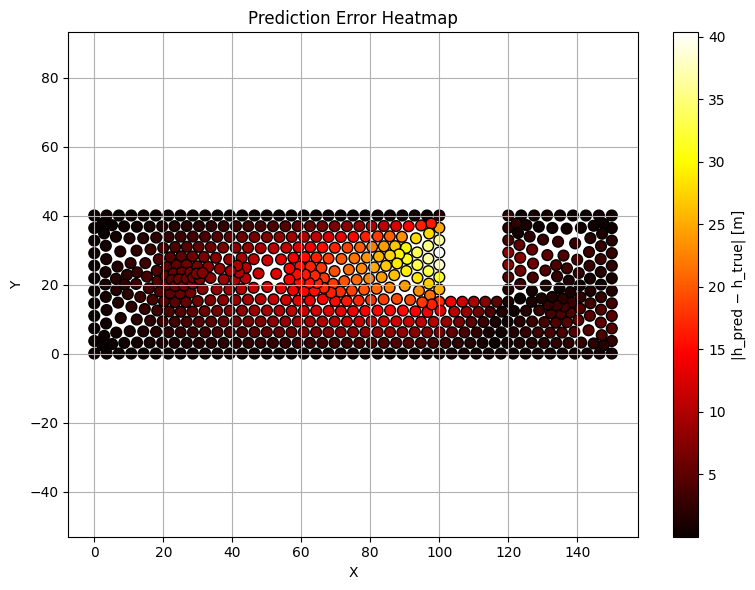

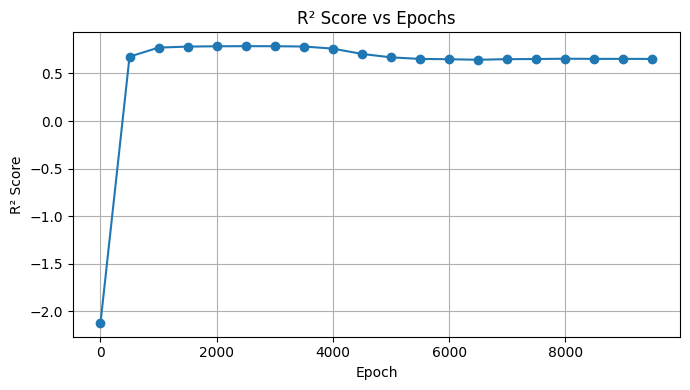

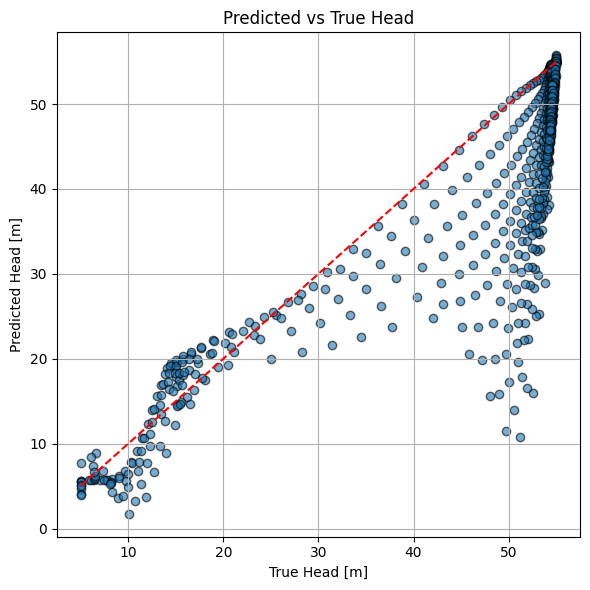

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from google.colab import files

# Upload the CSV
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)

# Parse h1, h2 from filename (e.g. "55_5_25.csv")
parts = filename.split('.')[0].split('_')
h1 = float(parts[0])
h2 = float(parts[1])

# Extract data
x_raw = data["X"].values.astype(np.float32)
y_raw = data["Y"].values.astype(np.float32)
h_raw = data["FINIT"].values.astype(np.float32)

# Normalization
x_min, x_max = x_raw.min(), x_raw.max()
y_min, y_max = y_raw.min(), y_raw.max()
h_max = h_raw.max()

x_norm = (x_raw - x_min) / (x_max - x_min)
y_norm = (y_raw - y_min) / (y_max - y_min)
h_norm = h_raw / h_max

# Standardize h1, h2 (for input)
h_mean = h_raw.mean()
h_std = h_raw.std()
h1_scaled = (h1 - h_mean) / h_std
h2_scaled = (h2 - h_mean) / h_std

# Build input with h1, h2 broadcasted
h1_column = np.full_like(x_norm, h1_scaled)
h2_column = np.full_like(x_norm, h2_scaled)
input_array = np.stack([x_norm, y_norm, h1_column, h2_column], axis=1)

xy_all = torch.tensor(input_array, dtype=torch.float32)
h_all = torch.tensor(h_norm, dtype=torch.float32).unsqueeze(1)

# Masks
boundary_mask = (
    (np.isclose(x_raw, x_min)) | (np.isclose(x_raw, x_max)) |
    (np.isclose(y_raw, y_min)) | (np.isclose(y_raw, y_max))
)
interior_mask = ~boundary_mask
xy_boundary = xy_all[boundary_mask]
h_boundary = h_all[boundary_mask]
xy_interior = xy_all[interior_mask]

bottom_mask = np.isclose(y_raw, y_min)
dam_wall_mask = np.isclose(x_raw, x_max)
xy_neu_bottom = xy_all[bottom_mask]
xy_neu_dam = xy_all[dam_wall_mask]

# ✅ 4-layer MLP model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model = PINN()

# Losses
def loss_dirichlet(xy, h_true): return torch.mean((model(xy) - h_true)**2)

def loss_laplace(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    h_x, h_y = grad[:, 0:1], grad[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    return torch.mean((h_xx + h_yy)**2)

def loss_neumann_y_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 1:2]**2)

def loss_neumann_x_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 0:1]**2)

# 🧠 Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

# Training: Adam
r2_vals = []
for epoch in range(10000):
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)

    total_loss = 20.0 * bc + 1.0 * pde + 1.0 * neu_y + 1.0 * neu_x
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        pred_temp = model(xy_all).detach().numpy().squeeze() * h_max
        r2_vals.append(r2_score(h_raw, pred_temp))
        print(f"Epoch {epoch:5d} | Total: {total_loss.item():.4f} | R²: {r2_vals[-1]:.5f}")

# 🧠 Polishing: L-BFGS
print("\n🔧 Switching to L-BFGS optimizer...")
optimizer = torch.optim.LBFGS(model.parameters(), max_iter=500, history_size=50)

def closure():
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20.0 * bc + 1.0 * pde + 1.0 * neu_y + 1.0 * neu_x
    total.backward()
    return total

optimizer.step(closure)

# 🔍 Final prediction
with torch.no_grad():
    h_pred = model(xy_all).numpy().squeeze() * h_max

# ✅ Final R²
r2 = r2_score(h_raw, h_pred)
print(f"\n📈 Final R² Score: {r2:.5f}")

# 📊 Field plot
plt.figure(figsize=(8, 6))
plt.scatter(x_raw, y_raw, c=h_pred, cmap="viridis", edgecolors="k", s=60)
plt.colorbar(label="Predicted Head [m]")
plt.title("Predicted Pressure Field (Final)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Error heatmap
plt.figure(figsize=(8, 6))
error = np.abs(h_raw - h_pred)
plt.scatter(x_raw, y_raw, c=error, cmap="hot", edgecolors="k", s=60)
plt.colorbar(label="|h_pred − h_true| [m]")
plt.title("Prediction Error Heatmap")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 R² vs Epochs
plt.figure(figsize=(7, 4))
plt.plot(np.arange(0, len(r2_vals)) * 500, r2_vals, marker="o")
plt.title("R² Score vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🎯 Predicted vs True Head
plt.figure(figsize=(6, 6))
plt.scatter(h_raw, h_pred, alpha=0.6, edgecolors="k")
plt.plot([h_raw.min(), h_raw.max()], [h_raw.min(), h_raw.max()], 'r--')
plt.xlabel("True Head [m]")
plt.ylabel("Predicted Head [m]")
plt.title("Predicted vs True Head")
plt.grid(True)
plt.tight_layout()
plt.show()


Saving 55_5_25.csv to 55_5_25 (5).csv
Epoch 0 | R²: -4.81091 | Loss: 6.6264
Epoch 500 | R²: 0.91056 | Loss: 0.2984
Epoch 1000 | R²: 0.90220 | Loss: 0.0055
Epoch 1500 | R²: 0.90179 | Loss: 0.0022
Epoch 2000 | R²: 0.90208 | Loss: 0.0012
Epoch 2500 | R²: 0.90457 | Loss: 0.0007
Epoch 3000 | R²: 0.90825 | Loss: 0.0007
Epoch 3500 | R²: 0.91102 | Loss: 0.0003
Epoch 4000 | R²: 0.91405 | Loss: 0.0003
Epoch 4500 | R²: 0.91482 | Loss: 0.0072
Epoch 5000 | R²: 0.91919 | Loss: 0.0002
Epoch 5500 | R²: 0.91965 | Loss: 0.0060
Epoch 6000 | R²: 0.92302 | Loss: 0.0004
Epoch 6500 | R²: 0.92469 | Loss: 0.0001
Epoch 7000 | R²: 0.92511 | Loss: 0.0006
Epoch 7500 | R²: 0.92465 | Loss: 0.0039
Epoch 8000 | R²: 0.92605 | Loss: 0.0002
Epoch 8500 | R²: 0.92702 | Loss: 0.0001
Epoch 9000 | R²: 0.92775 | Loss: 0.0001
Epoch 9500 | R²: 0.92831 | Loss: 0.0005

🔧 L-BFGS Polishing...

📈 Final R² Score: 0.93033


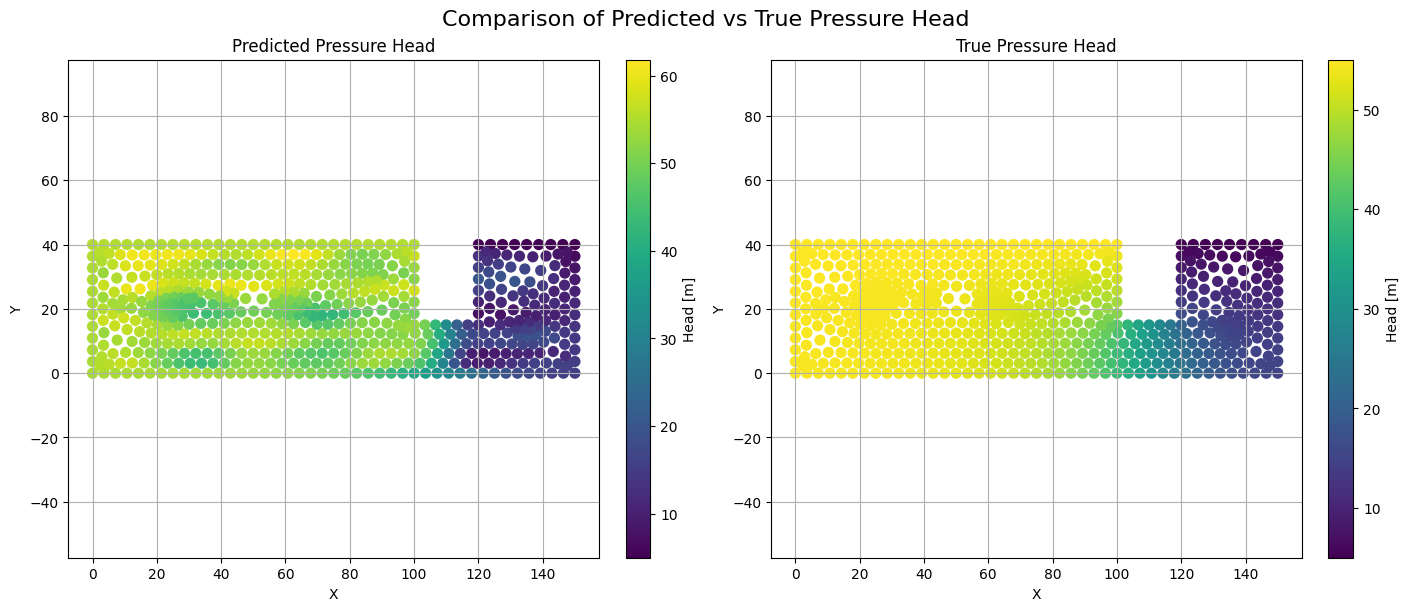

In [7]:
# %matplotlib inline  # optional in Google Colab, usually auto-enabled

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from google.colab import files

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Upload CSV ---
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)

# --- Extract h1, h2 from filename (e.g., "55_5_25.csv") ---
parts = filename.split('.')[0].split('_')
h1, h2 = float(parts[0]), float(parts[1])

# --- Extract and normalize coordinates and head values ---
x_raw = data["X"].values.astype(np.float32)
y_raw = data["Y"].values.astype(np.float32)
h_raw = data["FINIT"].values.astype(np.float32)

x_min, x_max = x_raw.min(), x_raw.max()
y_min, y_max = y_raw.min(), y_raw.max()
h_max = h_raw.max()

x_norm = (x_raw - x_min) / (x_max - x_min)
y_norm = (y_raw - y_min) / (y_max - y_min)
h_norm = h_raw / h_max

# --- Standardize h1, h2 ---
h_mean = h_raw.mean()
h_std = h_raw.std()
h1_scaled = (h1 - h_mean) / h_std
h2_scaled = (h2 - h_mean) / h_std

h1_col = np.full_like(x_norm, h1_scaled)
h2_col = np.full_like(x_norm, h2_scaled)
input_array = np.stack([x_norm, y_norm, h1_col, h2_col], axis=1)
xy_raw = torch.tensor(input_array, dtype=torch.float32).to(DEVICE)
h_all = torch.tensor(h_norm, dtype=torch.float32).unsqueeze(1).to(DEVICE)

# --- Fourier Features ---
def add_fourier_features(xy, n_freqs=4):
    base = [xy]
    x, y = xy[:, 0:1], xy[:, 1:2]
    for i in range(1, n_freqs + 1):
        for fn in [torch.sin, torch.cos]:
            base.append(fn(2 * np.pi * i * x))
            base.append(fn(2 * np.pi * i * y))
    base.append(xy[:, 2:])  # h1, h2 remain unchanged
    return torch.cat(base, dim=1)

xy_all = add_fourier_features(xy_raw)

# --- Masks for BCs and PDE enforcement ---
x_raw_t, y_raw_t = torch.tensor(x_raw), torch.tensor(y_raw)
boundary_mask = (
    (torch.isclose(x_raw_t, torch.tensor(x_min))) |
    (torch.isclose(x_raw_t, torch.tensor(x_max))) |
    (torch.isclose(y_raw_t, torch.tensor(y_min))) |
    (torch.isclose(y_raw_t, torch.tensor(y_max)))
)
interior_mask = ~boundary_mask

xy_boundary = xy_all[boundary_mask].to(DEVICE)
h_boundary = h_all[boundary_mask].to(DEVICE)
xy_interior = xy_all[interior_mask].to(DEVICE)

bottom_mask = torch.isclose(y_raw_t, torch.tensor(y_min))
dam_mask = torch.isclose(x_raw_t, torch.tensor(x_max))
xy_neu_bottom = xy_all[bottom_mask].to(DEVICE)
xy_neu_dam = xy_all[dam_mask].to(DEVICE)

# --- Model ---
class PINN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model = PINN(in_dim=xy_all.shape[1]).to(DEVICE)

# --- Xavier initialization ---
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# --- Loss functions ---
def loss_dirichlet(xy, h_true): return torch.mean((model(xy) - h_true) ** 2)

def loss_laplace(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    h_x, h_y = grad[:, 0:1], grad[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    return torch.mean((h_xx + h_yy) ** 2)

def loss_neumann_y_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 1:2] ** 2)

def loss_neumann_x_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 0:1] ** 2)

# --- Optimizer & Scheduler ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

# --- Train with Adam ---
r2_vals = []

for epoch in range(10000):
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20 * bc + 100 * pde + 1 * neu_y + 1 * neu_x
    total.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        pred_temp = model(xy_all).detach().cpu().numpy().squeeze() * h_max
        r2_vals.append(r2_score(h_raw, pred_temp))
        print(f"Epoch {epoch} | R²: {r2_vals[-1]:.5f} | Loss: {total.item():.4f}")

# --- L-BFGS Polishing ---
print("\n🔧 L-BFGS Polishing...")
optimizer = torch.optim.LBFGS(model.parameters(), max_iter=1000, line_search_fn="strong_wolfe")

def closure():
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20 * bc + 1 * pde + 1 * neu_y + 1 * neu_x
    total.backward()
    return total

optimizer.step(closure)

# --- Final prediction
with torch.no_grad():
    h_pred = model(xy_all).cpu().numpy().squeeze() * h_max

# --- Evaluation and plots
r2 = r2_score(h_raw, h_pred)
print(f"\n📈 Final R² Score: {r2:.5f}")

fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# --- Plot 1: Predicted Head
sc0 = axs[0].scatter(x_raw, y_raw, c=h_pred, cmap="viridis", edgecolors="face", s=50)
axs[0].set_title("Predicted Pressure Head")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].axis("equal")
axs[0].grid(True)
plt.colorbar(sc0, ax=axs[0], label="Head [m]")

# --- Plot 2: True Head
sc1 = axs[1].scatter(x_raw, y_raw, c=h_raw, cmap="viridis", edgecolors="face", s=50)
axs[1].set_title("True Pressure Head")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].axis("equal")
axs[1].grid(True)
plt.colorbar(sc1, ax=axs[1], label="Head [m]")

plt.suptitle("Comparison of Predicted vs True Pressure Head", fontsize=16)
plt.show()


Saving 55_5_25.csv to 55_5_25.csv
Epoch 0 | R²: -2.72000 | Loss: 22.8559
Epoch 500 | R²: 0.90712 | Loss: 0.0623
Epoch 1000 | R²: 0.91505 | Loss: 0.0071
Epoch 1500 | R²: 0.91224 | Loss: 0.0033
Epoch 2000 | R²: 0.90328 | Loss: 0.0025
Epoch 2500 | R²: 0.89658 | Loss: 0.0018
Epoch 3000 | R²: 0.88998 | Loss: 0.0008
Epoch 3500 | R²: 0.88300 | Loss: 0.0007
Epoch 4000 | R²: 0.87600 | Loss: 0.0004
Epoch 4500 | R²: 0.87261 | Loss: 0.0003
Epoch 5000 | R²: 0.86883 | Loss: 0.0382
Epoch 5500 | R²: 0.86349 | Loss: 0.0002
Epoch 6000 | R²: 0.85892 | Loss: 0.0002
Epoch 6500 | R²: 0.85646 | Loss: 0.0001
Epoch 7000 | R²: 0.85420 | Loss: 0.0005
Epoch 7500 | R²: 0.84955 | Loss: 0.0001
Epoch 8000 | R²: 0.84403 | Loss: 0.0123
Epoch 8500 | R²: 0.84443 | Loss: 0.0001
Epoch 9000 | R²: 0.84096 | Loss: 0.0001
Epoch 9500 | R²: 0.83930 | Loss: 0.0000

🔧 L-BFGS Polishing...

📈 Final R² Score: 0.82593


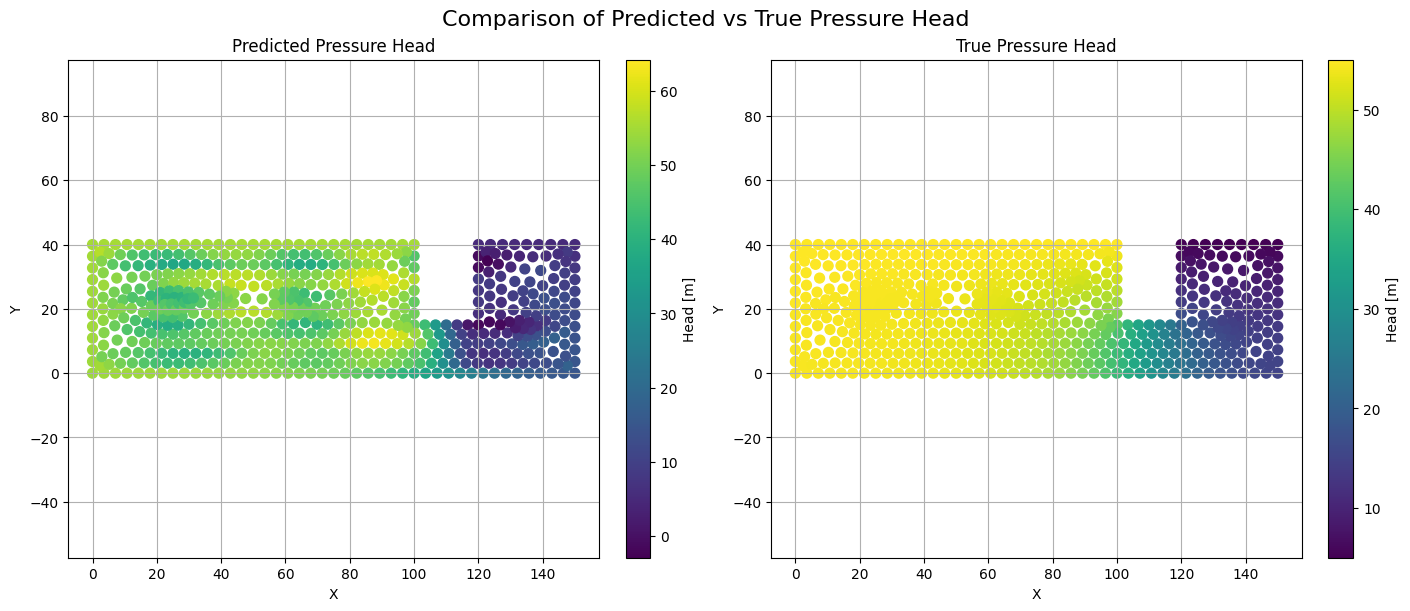

In [1]:
# %matplotlib inline  # optional in Google Colab, usually auto-enabled

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from google.colab import files

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Upload CSV ---
uploaded = files.upload()
filename = list(uploaded.keys())[0]
data = pd.read_csv(filename)

# --- Extract h1, h2 from filename (e.g., "55_5_25.csv") ---
parts = filename.split('.')[0].split('_')
h1, h2 = float(parts[0]), float(parts[1])

# --- Extract and normalize coordinates and head values ---
x_raw = data["X"].values.astype(np.float32)
y_raw = data["Y"].values.astype(np.float32)
h_raw = data["FINIT"].values.astype(np.float32)

x_min, x_max = x_raw.min(), x_raw.max()
y_min, y_max = y_raw.min(), y_raw.max()
h_max = h_raw.max()

x_norm = (x_raw - x_min) / (x_max - x_min)
y_norm = (y_raw - y_min) / (y_max - y_min)
h_norm = h_raw / h_max

# --- Standardize h1, h2 ---
h_mean = h_raw.mean()
h_std = h_raw.std()
h1_scaled = (h1 - h_mean) / h_std
h2_scaled = (h2 - h_mean) / h_std

h1_col = np.full_like(x_norm, h1_scaled)
h2_col = np.full_like(x_norm, h2_scaled)
input_array = np.stack([x_norm, y_norm, h1_col, h2_col], axis=1)
xy_raw = torch.tensor(input_array, dtype=torch.float32).to(DEVICE)
h_all = torch.tensor(h_norm, dtype=torch.float32).unsqueeze(1).to(DEVICE)

# --- Fourier Features ---
def add_fourier_features(xy, n_freqs=4):
    base = [xy]
    x, y = xy[:, 0:1], xy[:, 1:2]
    for i in range(1, n_freqs + 1):
        for fn in [torch.sin, torch.cos]:
            base.append(fn(2 * np.pi * i * x))
            base.append(fn(2 * np.pi * i * y))
    base.append(xy[:, 2:])  # h1, h2 remain unchanged
    return torch.cat(base, dim=1)

xy_all = add_fourier_features(xy_raw)

# --- Masks for BCs and PDE enforcement ---
x_raw_t, y_raw_t = torch.tensor(x_raw), torch.tensor(y_raw)
boundary_mask = (
    (torch.isclose(x_raw_t, torch.tensor(x_min))) |
    (torch.isclose(x_raw_t, torch.tensor(x_max))) |
    (torch.isclose(y_raw_t, torch.tensor(y_min))) |
    (torch.isclose(y_raw_t, torch.tensor(y_max)))
)
interior_mask = ~boundary_mask

xy_boundary = xy_all[boundary_mask].to(DEVICE)
h_boundary = h_all[boundary_mask].to(DEVICE)
xy_interior = xy_all[interior_mask].to(DEVICE)

bottom_mask = torch.isclose(y_raw_t, torch.tensor(y_min))
dam_mask = torch.isclose(x_raw_t, torch.tensor(x_max))
xy_neu_bottom = xy_all[bottom_mask].to(DEVICE)
xy_neu_dam = xy_all[dam_mask].to(DEVICE)

# --- Model ---
class PINN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model = PINN(in_dim=xy_all.shape[1]).to(DEVICE)

# --- Xavier initialization ---
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)

# --- Loss functions ---
def loss_dirichlet(xy, h_true): return torch.mean((model(xy) - h_true) ** 2)

def loss_laplace(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    h_x, h_y = grad[:, 0:1], grad[:, 1:2]
    h_xx = torch.autograd.grad(h_x, xy, torch.ones_like(h_x), create_graph=True)[0][:, 0:1]
    h_yy = torch.autograd.grad(h_y, xy, torch.ones_like(h_y), create_graph=True)[0][:, 1:2]
    return torch.mean((h_xx + h_yy) ** 2)

def loss_neumann_y_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 1:2] ** 2)

def loss_neumann_x_zero(xy):
    xy.requires_grad_(True)
    h = model(xy)
    grad = torch.autograd.grad(h, xy, torch.ones_like(h), create_graph=True)[0]
    return torch.mean(grad[:, 0:1] ** 2)

# --- Optimizer & Scheduler ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

# --- Train with Adam ---
r2_vals = []

for epoch in range(10000):
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20 * bc + 100 * pde + 1 * neu_y + 1 * neu_x
    total.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        pred_temp = model(xy_all).detach().cpu().numpy().squeeze() * h_max
        r2_vals.append(r2_score(h_raw, pred_temp))
        print(f"Epoch {epoch} | R²: {r2_vals[-1]:.5f} | Loss: {total.item():.4f}")

# --- L-BFGS Polishing ---
print("\n🔧 L-BFGS Polishing...")
optimizer = torch.optim.LBFGS(model.parameters(), max_iter=1000, line_search_fn="strong_wolfe")

def closure():
    optimizer.zero_grad()
    bc = loss_dirichlet(xy_boundary, h_boundary)
    pde = loss_laplace(xy_interior)
    neu_y = loss_neumann_y_zero(xy_neu_bottom)
    neu_x = loss_neumann_x_zero(xy_neu_dam)
    total = 20 * bc + 1 * pde + 1 * neu_y + 1 * neu_x
    total.backward()
    return total

optimizer.step(closure)

# --- Final prediction
with torch.no_grad():
    h_pred = model(xy_all).cpu().numpy().squeeze() * h_max

# --- Evaluation and plots
r2 = r2_score(h_raw, h_pred)
print(f"\n📈 Final R² Score: {r2:.5f}")



fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# --- Plot 1: Predicted Head
sc0 = axs[0].scatter(x_raw, y_raw, c=h_pred, cmap="viridis", edgecolors="face", s=50)
axs[0].set_title("Predicted Pressure Head")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].axis("equal")
axs[0].grid(True)
plt.colorbar(sc0, ax=axs[0], label="Head [m]")

# --- Plot 2: True Head
sc1 = axs[1].scatter(x_raw, y_raw, c=h_raw, cmap="viridis", edgecolors="face", s=50)
axs[1].set_title("True Pressure Head")
axs[1].set_xlabel("X")
axs[1].set_ylabel("Y")
axs[1].axis("equal")
axs[1].grid(True)
plt.colorbar(sc1, ax=axs[1], label="Head [m]")

plt.suptitle("Comparison of Predicted vs True Pressure Head", fontsize=16)
plt.show()